### Описание проекта:
В рамках проекта у нас была поставлена задача создать решение для предсказания, совершит ли покупатель повторную покупку в течение ближайших 30 дней. Мы работали с информацией по трём интернет-магазинам различных категорий и анализировали обезличенную историю покупок клиентов за определенный период. Проект включал предсказание как на статичных данных, так и на временных рядах с использованием моделей keras, включающих слой LSTM.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from keras.models import Model
from keras.layers import LSTM, Dense, Masking, Input, Concatenate, Reshape
from keras.metrics import AUC
from keras.utils import pad_sequences, plot_model, set_random_seed
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import RFE
from catboost import CatBoostClassifier, Pool

warnings.filterwarnings("ignore")

In [3]:
MASK_VALUE = 999999
set_random_seed(42)
np.random.seed(42)

In [4]:
is_holiday_22_23 = pd.to_datetime([
    "2022-01-01", "2022-01-02", "2022-01-03", "2022-01-04", "2022-01-05", "2022-01-06", "2022-01-08", "2022-01-07",
    "2022-02-23", "2022-03-08", "2022-05-01", "2022-05-02", "2022-05-09", "2022-06-12", "2022-06-13", "2022-11-04",
    "2023-01-01", "2023-01-02", "2023-01-03", "2023-01-04", "2023-01-05", "2023-01-06", "2023-01-08", "2023-01-07",
    "2023-02-23", "2023-03-08", "2023-05-01", "2023-05-09", "2023-06-12", "2023-11-04", "2023-02-24", "2023-05-08",
    "2023-11-06"
])

- marketplace - мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц;
- apparel - магазин одежды, по характеристикам похожий на маркетплейс;
- gifts – магазин подарков, очень маленький;
- client_id – идентификатор клиента;
- quantity – количество товара в заказе;
- price – цена 1 единицы товара в заказе;
- message_id – идентификатор сообщения из рассылки;
- date – дата покупки;

🔸изучить предоставленные данные
🔸создать полезные признаки для обучения модели
🔸создать целевой признак
🔸предложить и обосновать метрику
🔸обучить модель
🔸протестировать и проверить

In [5]:
data_apparel_purchases = pd.read_csv('D:\\\Masterskaya\\market_place\\data\\apparel-purchases.csv')
data_gifts_purchases = pd.read_csv('D:\\\Masterskaya\\market_place\\data\\gifts-purchases.csv')
data_marketplace_purchases = pd.read_csv('D:\\\Masterskaya\\market_place\\data\\marketplace-purchases.csv')

In [6]:
print(data_apparel_purchases.shape)
data_apparel_purchases.head(1)

(133104, 6)


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message


### Функция для визуализации количества и объема продаж, а так же числа покупателей 

In [7]:
def plot_sales_statistics(data):
    # Преобразование столбца 'created_at' в тип datetime
    data['date'] = pd.to_datetime(data['date'])

    # Извлечение месяца из столбца 'created_at'
    data['month'] = data['date'].dt.to_period('M')

    # Группировка данных по месяцам и подсчет числа продаж
    sales_per_month = data.groupby('month').size().reset_index(name='count')

    # Группировка данных по месяцам и вычисление суммы цен продаж
    total_sales_per_month = data.groupby('month')['price'].sum().reset_index(name='total_price')
    
    plt.style.use('dark_background')
    plt.rcParams.update({"grid.linewidth":0.3, "grid.alpha":0.5})
    # Создание общего рисунка и подграфиков
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Построение графика числа продаж по месяцам
    sns.barplot(x='month', y='count', data=sales_per_month, color='skyblue', ax=ax1)
    ax1.set_title('Количество  продаж за месяц')
    ax1.set_xticklabels(sales_per_month['month'], rotation=45)
    ax1.set_xlabel('Месяц')
    ax1.set_ylabel('Количество продаж')

    # Построение графика суммарной стоимости продаж по месяцам
    sns.barplot(x='month', y='total_price', data=total_sales_per_month, color='salmon', ax=ax2)
    ax2.set_title('Ежемесячный объем продаж')
    ax2.set_xticklabels(total_sales_per_month['month'], rotation=45)
    ax2.set_xlabel('Месяц')
    ax2.set_ylabel('Сумма продаж за месяц')
    
    data['date'] = pd.to_datetime(data['date'])
    data['month'] = data['date'].dt.to_period('M')

    # Найдем новых клиентов для каждого месяца
    first_purchase_per_customer = data.groupby('client_id')['month'].min().reset_index()
    new_customers_per_month = first_purchase_per_customer.groupby('month').size().reset_index(name='new_customers')
    #new_customers_per_month = data.drop_duplicates('client_id').groupby('month').size().reset_index(name='new_customers')

    # Найдем общее количество клиентов для каждого месяца
    total_customers_per_month = data.groupby('month')['client_id'].nunique().reset_index(name='total_customers')

    # Объединим данные по новым и общим клиентам
    customers_data = pd.merge(total_customers_per_month, new_customers_per_month, on='month')

    sns.set_color_codes("pastel")
    sns.barplot(x='month', y='new_customers', data=customers_data, label='Новые покупатели', color='b', alpha=0.7, ax=ax3)

    sns.set_color_codes("muted")
    sns.barplot(x='month', y='total_customers', data=customers_data, label='Всего покупателей', color='b', alpha=0.7, ax=ax3)

    ax3.set_title('Уникальные покупатели и новые покупатели')
    ax3.set_xticklabels(total_sales_per_month['month'], rotation=45)
    ax3.set_xlabel('Месяц')
    ax3.set_ylabel('Количество покупателей')
    ax3.legend(loc='upper left', frameon=False)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4)  # Увеличиваем расстояние между подграфиками
    plt.show()



In [8]:
data_apparel_purchases['recommended_by'].value_counts()

recommended_by
bulk_message    133104
Name: count, dtype: int64

(133104, 6)


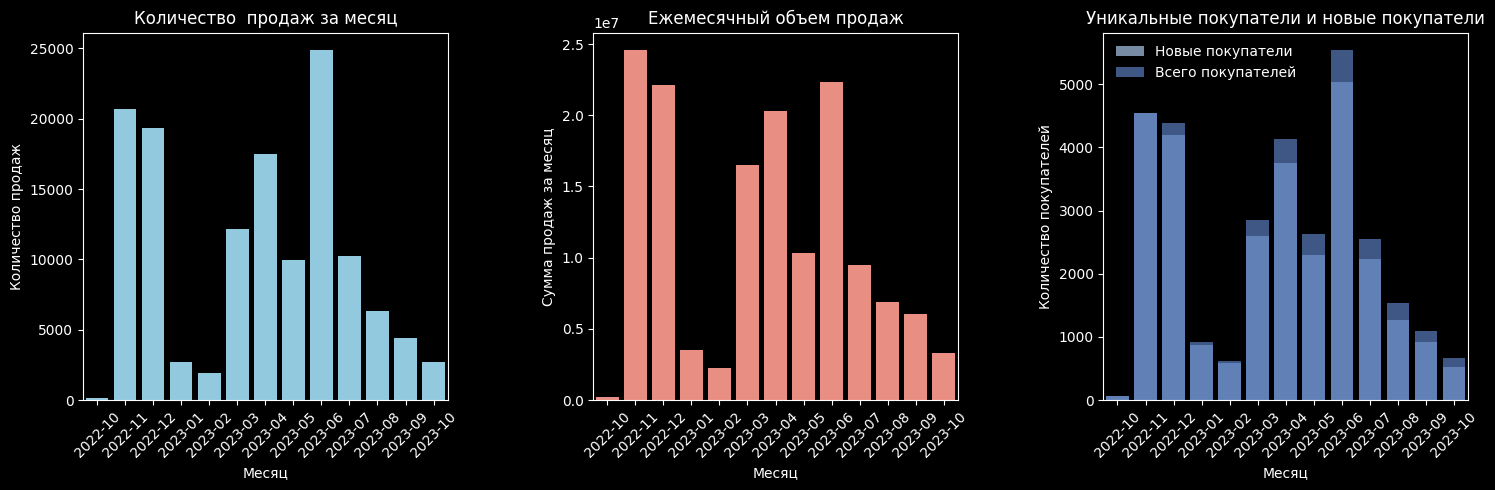

,client_id,quantity,price,date,message_id,recommended_by,month
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message,2023-09


In [9]:
print(data_apparel_purchases.shape)
plot_sales_statistics(data_apparel_purchases)
data_apparel_purchases.head(1)

(811, 6)


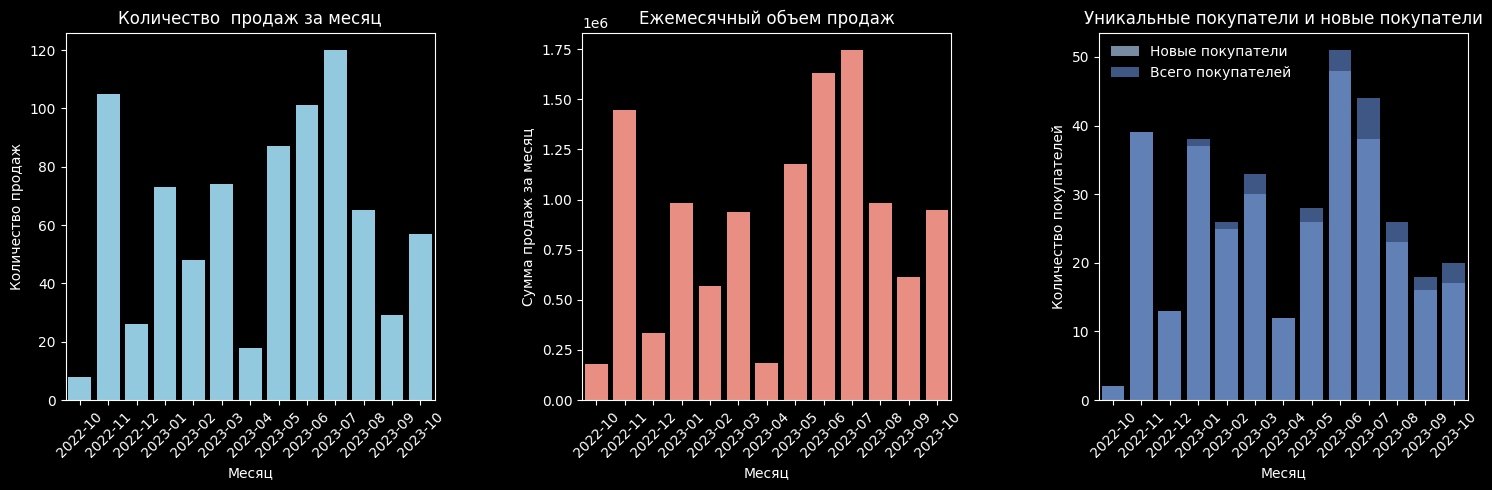

,client_id,quantity,price,date,message_id,recommended_by,month
0,1515915625803894158,1,8943.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message,2023-10


In [10]:
print(data_gifts_purchases.shape)
plot_sales_statistics(data_gifts_purchases)
data_gifts_purchases.head(1)

(48182, 6)


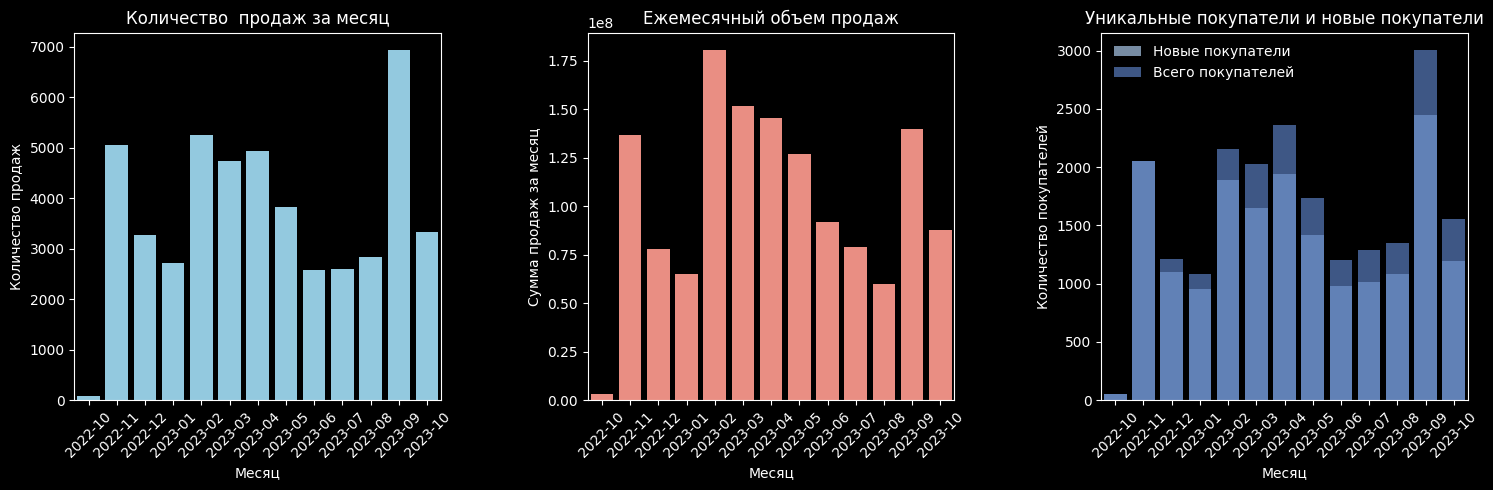

,client_id,quantity,price,message_id,created_at,date,month
0,1515915625440944408,1,6298.0,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57,2023-05


In [11]:
print(data_marketplace_purchases.shape)
plot_sales_statistics(data_marketplace_purchases)
data_marketplace_purchases.head(1)

In [12]:
# Объединим таблицы и добавим колонку категории магазина.

data_apparel_purchases['store_category_id'] = 1
data_marketplace_purchases['store_category_id'] = 2
data_gifts_purchases['store_category_id'] = 3

# Объединение таблиц
combined_data = pd.concat([data_apparel_purchases, data_marketplace_purchases, data_gifts_purchases], ignore_index=True).copy()

(182097, 9)


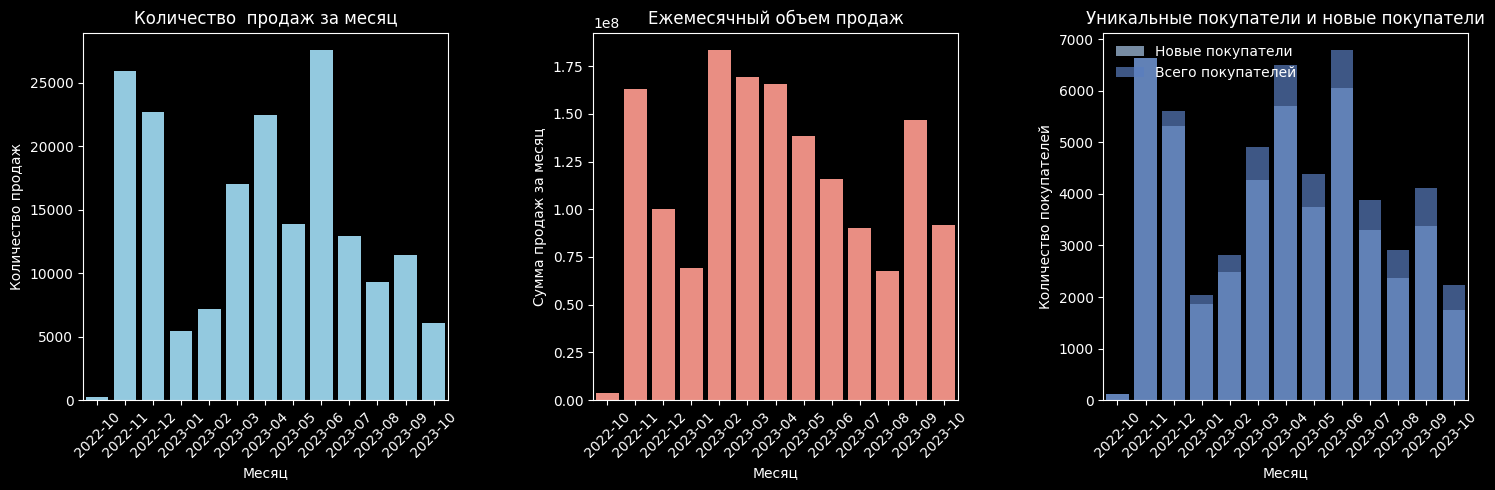

,client_id,quantity,price,date,message_id,recommended_by,month,store_category_id,created_at
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message,2023-09,1,NaN


In [13]:
print(combined_data.shape)
plot_sales_statistics(combined_data)
combined_data.head(1)

In [14]:
combined_data['message_id'].value_counts().sum

<bound method Series.sum of message_id
1515915625489095763-6251-6311b13a4cf78     271
1515915625624308268-7803-636dfea7ca890     218
1515915625557752721-1909-64942a0b0e7f5     180
1515915625880116527-8725-639b2f0ad5e2e     160
1515915625607113301-13818-650a8af70fd67    148
                                          ... 
1515915625536120644-1985-64b8c802294a5       1
1515915625685286173-8033-637dbe2e0c234       1
1515915625536533267-1965-64abd0808d6c9       1
1515915625536556344-1964-64a54c3f45b1f       1
1515915625524007589-2141-651bad036f2f8       1
Name: count, Length: 46708, dtype: int64>

Сделаем категориальный признак из message_id и закодируем в числовой формат

In [15]:
# Кодирование message_id в числовой формат
encoder = LabelEncoder()
combined_data['message_id_encoded'] = encoder.fit_transform(combined_data['message_id'])

# Удаление исходного столбца message_id
combined_data.drop('message_id', axis=1, inplace=True)

In [16]:
combined_data['recommended_by'].value_counts()

recommended_by
bulk_message    133915
Name: count, dtype: int64

In [17]:
# recommended_by не несет смысла, drop
combined_data = combined_data.drop(columns=['recommended_by','month'])

In [18]:
combined_data[combined_data.duplicated()]

,client_id,quantity,price,date,store_category_id,created_at,message_id_encoded
1,1515915625468068833,1,3499.0,2023-09-08,1,NaN,1363
2,1515915625468068833,1,3499.0,2023-09-08,1,NaN,1363
4,1515915625468068833,1,2450.0,2023-09-08,1,NaN,1363
5,1515915625468068833,1,2450.0,2023-09-08,1,NaN,1363
10,1515915625468079941,1,1499.0,2023-09-01,1,NaN,1474
...,...,...,...,...,...,...,...
182079,1515915625862783809,1,5194.0,2022-11-08,3,NaN,44023
182080,1515915625862783809,1,5194.0,2022-11-08,3,NaN,44023
182081,1515915625862783809,1,5194.0,2022-11-08,3,NaN,44023
182084,1515915625864817073,1,1893.0,2022-11-11,3,NaN,44106


Будем считать, что дубликаты это множественные заказы или различные товары в один день.     
Агрегируем - объединим данные для дубликатов, суммируем количество и цену товаров. 

### Модель времянного ряда

In [19]:
data_grouped = combined_data.groupby(['client_id', 'date', 'store_category_id']).agg({'quantity': 'sum', 'price': 'sum', 'message_id_encoded': 'first'}).reset_index()
data_grouped.shape

(65576, 6)

In [20]:
# Сортировка данных по клиенту и дате
data_grouped = data_grouped.sort_values(['client_id', 'date'])

Создадим временные признаки, например, RFM (Recency, Frequency, Monetary) нарастающим итогом:

In [21]:
# Рассчитаем RFM нарастающим итогом
data_grouped['monetary'] = data_grouped.groupby('client_id')['price'].cumsum()
data_grouped['recency'] = data_grouped.groupby('client_id')['date'].diff().dt.days.fillna(999).astype(int)
data_grouped['frequency'] = data_grouped.groupby('client_id')['date'].cumcount() + 1

Рассчитаем разницу в датах для каждого клиента и получим количество дней до следующей покупки с помощью сдвига:

In [22]:
# data_grouped['days_to_next_purchase'] = data_grouped.groupby('client_id')['date'].diff().dt.days
data_grouped['days_to_next_purchase'] = -data_grouped.sort_values('date', ascending=False).groupby('client_id')['date'].diff().dt.days

Создадим целевую переменную, где 1 означает повторную покупку в течение 30 дней после заказа:

In [23]:
data_grouped['target'] = (data_grouped['days_to_next_purchase'] <= 30).astype(int)

In [24]:
data_grouped = data_grouped.sort_values(['date'])

In [25]:
# Найдем дату, на которую нужно удалить последние 30 дней
date_to_exclude = data_grouped['date'].max() - pd.Timedelta(days=30)

# Удалим данные за последние 30 дней
data_grouped = data_grouped[data_grouped['date'] < date_to_exclude]

In [26]:
data_grouped['frequency'].value_counts()

frequency
1      44678
2       8305
3       3016
4       1461
5        858
       ...  
120        1
121        1
122        1
123        1
144        1
Name: count, Length: 144, dtype: int64

In [27]:
# Скопировать data_grouped в features_time_s
features_time_s = data_grouped.copy()

# Создание признаков "день месяца", "день недели", "неделя месяца" и "является ли день выходным"
features_time_s['total_price'] = features_time_s['price'] * features_time_s['quantity']
features_time_s['day_of_month'] = features_time_s['date'].dt.day
features_time_s['day_of_week'] = features_time_s['date'].dt.dayofweek
features_time_s['month'] = features_time_s['date'].dt.month
features_time_s['week_of_year'] = features_time_s['date'].dt.isocalendar().week
features_time_s['week_of_month'] = features_time_s['date'].apply(lambda x: (x.day - 1) // 7 + 1)
features_time_s['is_weekend'] = features_time_s['day_of_week'].isin([5, 6]).astype(int)
features_time_s['is_holiday'] = features_time_s['date'].isin(is_holiday_22_23).astype(int)

# Создаем список дат на следующие 30 дней от каждой даты в features_time_s
date_ranges = [pd.date_range(date, periods=30) for date in features_time_s['date']]
# Создаем новый признак 'holidays_next_30_days'
features_time_s['holidays_next_30_days'] = [sum(1 for holiday in is_holiday_22_23 if holiday in date_range) for date_range in date_ranges]

In [28]:
features_time_s.head(3)

,client_id,date,store_category_id,quantity,price,message_id_encoded,monetary,recency,frequency,days_to_next_purchase,target,total_price,day_of_month,day_of_week,month,week_of_year,week_of_month,is_weekend,is_holiday,holidays_next_30_days
53849,1515915625587818098,2022-10-26,1,2,17998.0,9575,17998.0,999,1,NaN,0,35996.0,26,2,10,43,4,0,0,1
54008,1515915625588327029,2022-10-26,1,1,2499.0,37963,2499.0,999,1,NaN,0,2499.0,26,2,10,43,4,0,0,1
10138,1515915625489888679,2022-10-26,1,3,2213.0,9134,2213.0,999,1,NaN,0,6639.0,26,2,10,43,4,0,0,1


In [29]:
# Определяем целевой признак
X = features_time_s.drop(['date', 'client_id', 'days_to_next_purchase', 'target', 'total_price'], axis=1)
y = features_time_s['target']

# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
# # Сетка параметров для подбора
# grid = {'learning_rate': [0.15],
#         'depth': [10],
#         'l2_leaf_reg': [1, 2, 3],}

# # Инициализация модели CatBoost с использованием GPU
# model = CatBoostClassifier(iterations=1000, task_type='GPU', devices='0:1', verbose=False) 

# # Подбор лучших параметров с помощью Grid Search
# grid_search_result = model.grid_search(grid, X=Pool(X_train, label=y_train), plot=True)

# # Получение лучших параметров
# best_params = grid_search_result['params']

# # Создание модели с лучшими параметрами и использованием GPU
# best_model = CatBoostClassifier(iterations=1000, task_type='GPU', devices='0:1', verbose=False, **best_params)

In [31]:
best_params = {'depth': 10, 'l2_leaf_reg': 2, 'learning_rate': 0.15}

{'depth': 10, 'l2_leaf_reg': 2, 'learning_rate': 0.15}

In [32]:
# # Определение числа признаков, которые хотим оставить после RFE
# n_features_to_select = 5  # Вы можете выбрать желаемое количество признаков

# # Создание RFE с CatBoostClassifier
# rfe = RFE(estimator=best_model, n_features_to_select=n_features_to_select)

# # Обучение RFE
# rfe.fit(X_train, y_train)

# # Получение ранжированного списка признаков
# print("Ранжированные признаки:")
# for i in range(len(X.columns)):
#     if rfe.support_[i]:
#         print(X.columns[i])

In [33]:
best_model = CatBoostClassifier(iterations=1000, verbose=False, **best_params)

In [34]:
# Обучение модели на всей обучающей выборке
best_model.fit(X_train, y_train)

In [35]:
# # Обучение модели CatBoost с кросс-валидацией
# model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=0, loss_function='Logloss')

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc')

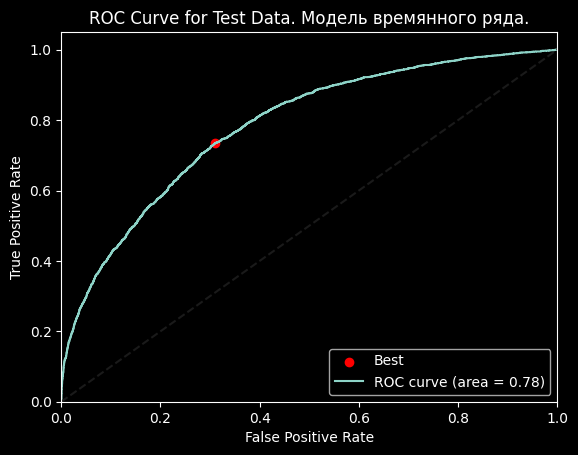

best threshold 0.134
ROC AUC на тестовой выборке: 0.7819876913323676


In [36]:
y_pred = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)

# Построение ROC-AUC кривой для тестового набора данных
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
idx = np.argmax(tpr - fpr)
best_thresh = thresholds[idx]
plt.figure()
plt.scatter(fpr[idx], tpr[idx], marker="o", color="red", label="Best")
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Data. Модель времянного ряда.')
plt.legend(loc="lower right")
plt.show()

# Предсказываем на тестовой выборке и вычисляем ROC AUC
y_pred_class = best_model.predict(X_test)
roc_auc_test = roc_auc_score(y_test, y_pred)
print('best threshold', best_thresh.round(3))
print(f'ROC AUC на тестовой выборке: {roc_auc_test}')

In [37]:
# Важность признаков
feature_importance = best_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print('Важность признаков:')
print(feature_importance_df)

Важность признаков:
                  Feature  Importance
3      message_id_encoded   16.489356
4                monetary   11.895679
7            day_of_month   11.710404
2                   price   11.501480
10           week_of_year   10.956223
8             day_of_week    9.644241
1                quantity    8.285575
5                 recency    4.512586
0       store_category_id    4.314623
6               frequency    3.048661
14  holidays_next_30_days    2.368136
9                   month    2.248764
11          week_of_month    1.563532
12             is_weekend    1.299608
13             is_holiday    0.161130


In [38]:
report = classification_report(y_test, y_pred > best_thresh, output_dict=True)
df_report = pd.DataFrame(report).round(2)
print(df_report)

                 0        1  accuracy  macro avg  weighted avg
precision     0.91     0.39       0.7       0.65          0.80
recall        0.69     0.73       0.7       0.71          0.70
f1-score      0.78     0.51       0.7       0.65          0.73
support    9716.00  2582.00       0.7   12298.00      12298.00


### Попробуем совместить получившуюся модель с keras 

In [39]:
data_grouped_seq = combined_data

# Добавляем поле total
data_grouped_seq['total'] = data_grouped_seq['price'] * data_grouped_seq['quantity']

data_grouped_seq = data_grouped_seq.sort_values(by='date')

# Группировка и добавление поля since_prev_purchase
data_grouped_seq['since_prev_purchase'] = (data_grouped_seq.groupby('client_id')['date'].diff().dt.days.fillna(0).astype(int))

# Выборка нужных столбцов
data_grouped_seq = data_grouped_seq[['client_id','date', 'message_id_encoded', 'total', 'since_prev_purchase']]

In [40]:

scaler = MinMaxScaler(feature_range=(0, 1))

features_to_scale = ['total', 'since_prev_purchase']
scaled_names = [f'{col}_scaled' for col in features_to_scale]
data_grouped_seq[scaled_names] = scaler.fit_transform(data_grouped_seq[features_to_scale])

features_seq = (data_grouped_seq.groupby(['client_id', 'date'])[scaled_names]
                  .agg(list).add_suffix('_seq').reset_index())

features_seq.head()


,client_id,date,total_scaled_seq,since_prev_purchase_scaled_seq
0,1515915625440099873,2023-07-16 08:25:31,[0.022727918447131557],[0.0]
1,1515915625440099873,2023-08-09 08:59:08,[0.0008651354668606237],[0.06760563380281691]
2,1515915625440939402,2023-01-30 13:13:37,[0.05398075961451041],[0.0]
3,1515915625440944408,2023-03-01 10:21:12,[0.0006264774070370033],[0.0]
4,1515915625440944408,2023-05-02 08:49:57,[0.004473418038003455],[0.17183098591549298]


In [41]:
# Удалим данные за последние 30 дней
features_seq = features_seq[features_seq['date'] < date_to_exclude]

In [42]:
features_seq.shape

(61487, 4)

In [43]:
filtered_features_seq = features_seq.drop(['client_id','date'], axis=1)

In [44]:
# Выравнивание последовательностей с использованием встроенной функции
X_seq = np.concatenate([
    pad_sequences(filtered_features_seq[col].values, dtype='float', value=MASK_VALUE, padding='post')[:, :, np.newaxis]
    for col in filtered_features_seq.columns
], axis=2)

# Нормализация X_time_s
scaler_time_s = MinMaxScaler(feature_range=(0, 1))
X_time_s = scaler_time_s.fit_transform(features_time_s.drop(['client_id','days_to_next_purchase','date','target'], axis=1))

X_seq.shape, X_time_s.shape

((61487, 216, 2), (61487, 16))

In [ ]:
# Разделение на обучающую и тестовую выборку
X_train_seq, X_test_seq, X_train_time_s, X_test_time_s, y_train, y_test = train_test_split(
    X_seq, X_time_s, y, test_size=0.2, random_state=42)

y = data_grouped['target']
display(data_grouped['target'].value_counts().to_frame().assign(percentage=lambda x: x/x.sum()).style.format({'percentage':'{:.2%}', 'target':'{:.0f}'}).set_caption('Распределение классов'))
y = y.values

y.shape

In [94]:
# Определение входных данных
input_seq = Input(shape=(X_train_seq.shape[1:]))
input_time_s = Input(shape=X_train_time_s.shape[1:])

# Слой маскирования для input_seq
module_seq = Masking(mask_value=MASK_VALUE)(input_seq)
module_seq = LSTM(16)(module_seq)

# Плотный слой для input_time_s
module_time_s = Dense(16, activation='relu')(input_time_s)

# Изменение формы module_seq
reshaped_module_seq = Reshape(target_shape=(16,))(module_seq)

# Сцепление выходных данных
merged = Concatenate()([reshaped_module_seq, module_time_s])

# Слой выходных данных
output = Dense(1, activation='sigmoid')(merged)

# Создание модели
model = Model(inputs=[input_seq, input_time_s], outputs=output)

# Компиляция модели
opt = Adam(learning_rate=0.001)  # Можно экспериментировать с коэффициентом обучения
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])

# Добавление обратных вызовов для отслеживания процесса обучения
callbacks = [
    ModelCheckpoint(filepath='best_model.h5', monitor='val_auc', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

# Обучение модели
history = model.fit(x=[X_train_seq, X_train_time_s], y=y_train, validation_split=0.25, epochs=10, batch_size=32, callbacks=callbacks)

# Оценка модели
loss, auc = model.evaluate([X_test_seq, X_test_time_s], y_test)
print(f'Тестовая ошибка: {loss}, Тестовая AUC: {auc}')

Epoch 1/10
1153/1153 [==============================] - 60s 49ms/step - loss: 0.4471 - auc: 0.7452 - val_loss: 0.4231 - val_auc: 0.7821
Epoch 2/10
1153/1153 [==============================] - 55s 48ms/step - loss: 0.4167 - auc: 0.7868 - val_loss: 0.4164 - val_auc: 0.7893
Epoch 3/10
1153/1153 [==============================] - 55s 48ms/step - loss: 0.4124 - auc: 0.7909 - val_loss: 0.4123 - val_auc: 0.7939
Epoch 4/10
1153/1153 [==============================] - 55s 48ms/step - loss: 0.4098 - auc: 0.7937 - val_loss: 0.4099 - val_auc: 0.7964
Epoch 5/10
1153/1153 [==============================] - 55s 48ms/step - loss: 0.4080 - auc: 0.7957 - val_loss: 0.4087 - val_auc: 0.7984
Epoch 6/10
1153/1153 [==============================] - 56s 48ms/step - loss: 0.4069 - auc: 0.7963 - val_loss: 0.4075 - val_auc: 0.7998
Epoch 7/10
1153/1153 [==============================] - 56s 49ms/step - loss: 0.4060 - auc: 0.7977 - val_loss: 0.4061 - val_auc: 0.8010
Epoch 8/10
1153/1153 [==========================

385/385 [==============================] - 4s 10ms/step


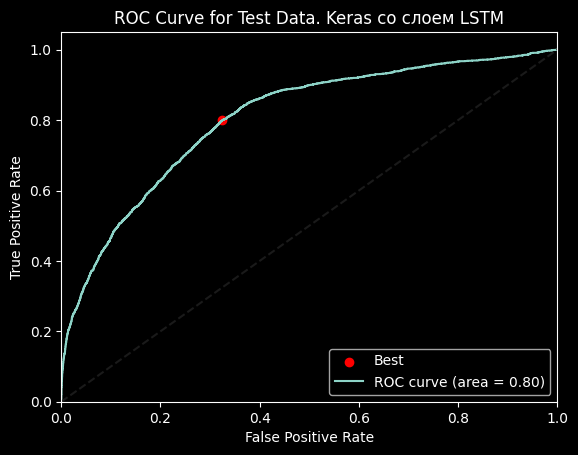

roc auc score 0.804
best threshold 0.211


,0,1,accuracy,macro avg,weighted avg
precision,0.93,0.40,0.7,0.66,0.81
recall,0.68,0.80,0.7,0.74,0.70
f1-score,0.78,0.53,0.7,0.66,0.73
support,9687.00,2611.00,0.7,12298.00,12298.00


In [97]:
y_pred = model.predict((X_test_seq, X_test_time_s)).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

idx = np.argmax(tpr - fpr)
best_thresh = thresholds[idx]

plt.figure()
plt.scatter(fpr[idx], tpr[idx], marker="o", color="red", label="Best")
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred).round(3))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Data. Keras со слоем LSTM')
plt.legend(loc="lower right")
plt.show()

print('roc auc score', roc_auc_score(y_test, y_pred).round(3))
print('best threshold', best_thresh.round(3))
pd.DataFrame(classification_report(y_test, y_pred>(best_thresh), output_dict=True)).round(2)

### Статичная модель

In [50]:
# Сортируем данные по дате
combined_data = combined_data.sort_values('date')

# Ищем последние 30 дней в данных о покупках
data_last_30_days = combined_data[combined_data['date'] >= combined_data['date'].max() - pd.DateOffset(days=30)]

# Исключаем последние 30 дней из других данных
data_wo_last_30_days = combined_data[combined_data['date'] < combined_data['date'].max() - pd.DateOffset(days=30)]

# Создание основных признаков
grouped_data_static = data_wo_last_30_days.groupby(['client_id', 'store_category_id'])
current_date = data_wo_last_30_days['date'].max()
features_static = grouped_data_static.agg(
    days_since_first_purchase=('date', lambda x: (current_date - x.min()).days),
    days_since_last_purchase=('date', lambda x: (current_date - x.max()).days),
    days_between_purchases_min=('date', lambda x: (x.max() - x.min()).days if len(x) > 1 else -999),
    days_between_purchases_mean=('date', lambda x: x.diff().dt.days.sum() / (len(x) - 1) if len(x) > 1 else -999),
    days_between_purchases_max=('date', lambda x: x.diff().dt.days.max() if len(x) > 1 else -999),
    total_products_bought=('quantity', 'sum'),
    total_purchases=('date', 'nunique'),
    average_purchase_price=('price', 'mean'),
    max_purchase_price=('price', 'max'),
    min_purchase_price=('price', 'min'),
    total_spent=('price', 'sum'),
    preferred_day_of_week=('date', lambda x: x.dt.dayofweek.mode()[0]),
    preferred_week_of_year=('date', lambda x: x.dt.isocalendar().week.mode()[0]),
    preferred_week_of_month=('date', lambda x: np.ceil(x.dt.day / 7).mode()[0]),                        
    most_common_message_id=('message_id_encoded', lambda x: x.value_counts().idxmax())).reset_index()

# Присвоение таргета
target_client_ids = data_last_30_days['client_id'].unique()
features_static['target'] = features_static['client_id'].isin(target_client_ids).astype(int)

# Вывод полученных признаков
features_static

,client_id,store_category_id,days_since_first_purchase,days_since_last_purchase,days_between_purchases_min,days_between_purchases_mean,days_between_purchases_max,total_products_bought,total_purchases,average_purchase_price,max_purchase_price,min_purchase_price,total_spent,preferred_day_of_week,preferred_week_of_year,preferred_week_of_month,most_common_message_id,target
0,1515915625440099873,2,72,48,24,24.000000,24.0,2,2,16608.000000,31998.0,1218.0,33216.0,2,28,2.0,0,0
1,1515915625440939402,2,239,239,-999,-999.000000,-999.0,1,1,75998.000000,75998.0,75998.0,75998.0,0,5,5.0,2,0
2,1515915625440944408,2,209,97,112,55.500000,61.0,3,3,27059.333333,73998.0,882.0,81178.0,2,9,1.0,3,0
3,1515915625440947454,2,323,275,47,15.666667,47.0,4,2,1121.500000,3998.0,2.0,4486.0,5,44,1.0,6,0
4,1515915625440952940,2,319,319,-999,-999.000000,-999.0,1,1,479.000000,479.0,479.0,479.0,4,45,2.0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44673,1515915625996380624,3,27,27,0,0.000000,0.0,6,1,11708.500000,33732.0,4040.0,70251.0,2,35,5.0,46689,0
44674,1515915625997511191,3,39,39,-999,-999.000000,-999.0,1,1,15043.000000,15043.0,15043.0,15043.0,4,33,3.0,46698,0
44675,1515915625997770678,3,39,39,0,0.000000,0.0,5,1,20835.400000,47549.0,1909.0,104177.0,4,33,3.0,46699,0
44676,1515915626005014483,3,13,13,-999,-999.000000,-999.0,1,1,7534.000000,7534.0,7534.0,7534.0,2,37,2.0,45265,0


In [51]:
# Отделяем целевую переменную от признаков
X = features_static.drop(['client_id', 'target'], axis=1)
y = features_static['target']

# Разбиваем на обучающую и тестовую выборки
X_train_static, X_test_static, y_train_static, y_test_static = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
display(features_static['target'].value_counts().to_frame().assign(percentage=lambda x: x/x.sum()).style.format({'percentage':'{:.2%}', 'target':'{:.0f}'}).set_caption('Распределение классов'))
X.shape, y.shape

,count,percentage
target,,
0,44023,98.53%
1,655,1.47%


((44678, 16), (44678,))

In [53]:
model_static = CatBoostClassifier(iterations=1500)  # best_params - параметры из предыдущих шагов
model_static.fit(X_train_static, y_train_static)

Learning rate set to 0.032709
0:	learn: 0.6211392	total: 11.5ms	remaining: 17.2s
1:	learn: 0.5583156	total: 19.4ms	remaining: 14.5s
2:	learn: 0.4988759	total: 27.7ms	remaining: 13.8s
3:	learn: 0.4505440	total: 35.9ms	remaining: 13.4s
4:	learn: 0.4094137	total: 44ms	remaining: 13.1s
5:	learn: 0.3728729	total: 52.1ms	remaining: 13s
6:	learn: 0.3396285	total: 60.5ms	remaining: 12.9s
7:	learn: 0.3107071	total: 68.6ms	remaining: 12.8s
8:	learn: 0.2845736	total: 76.9ms	remaining: 12.7s
9:	learn: 0.2603342	total: 84.9ms	remaining: 12.6s
10:	learn: 0.2399890	total: 90.6ms	remaining: 12.3s
11:	learn: 0.2211314	total: 99.6ms	remaining: 12.3s
12:	learn: 0.2053178	total: 108ms	remaining: 12.4s
13:	learn: 0.1914252	total: 116ms	remaining: 12.4s
14:	learn: 0.1776750	total: 125ms	remaining: 12.4s
15:	learn: 0.1656702	total: 133ms	remaining: 12.4s
16:	learn: 0.1558792	total: 141ms	remaining: 12.3s
17:	learn: 0.1468785	total: 150ms	remaining: 12.3s
18:	learn: 0.1384513	total: 159ms	remaining: 12.4s
19:

22:	learn: 0.1137948	total: 194ms	remaining: 12.4s
23:	learn: 0.1088078	total: 202ms	remaining: 12.4s
24:	learn: 0.1044989	total: 210ms	remaining: 12.4s
25:	learn: 0.1006421	total: 218ms	remaining: 12.4s
26:	learn: 0.0972436	total: 227ms	remaining: 12.4s
27:	learn: 0.0941363	total: 235ms	remaining: 12.4s
28:	learn: 0.0917138	total: 244ms	remaining: 12.4s
29:	learn: 0.0893253	total: 253ms	remaining: 12.4s
30:	learn: 0.0871203	total: 262ms	remaining: 12.4s
31:	learn: 0.0849828	total: 270ms	remaining: 12.4s
32:	learn: 0.0831738	total: 278ms	remaining: 12.3s
33:	learn: 0.0814966	total: 286ms	remaining: 12.3s
34:	learn: 0.0801745	total: 291ms	remaining: 12.2s
35:	learn: 0.0786875	total: 300ms	remaining: 12.2s
36:	learn: 0.0774342	total: 308ms	remaining: 12.2s
37:	learn: 0.0762423	total: 317ms	remaining: 12.2s
38:	learn: 0.0751693	total: 325ms	remaining: 12.2s
39:	learn: 0.0741784	total: 334ms	remaining: 12.2s
40:	learn: 0.0732629	total: 342ms	remaining: 12.2s
41:	learn: 0.0724194	total: 350

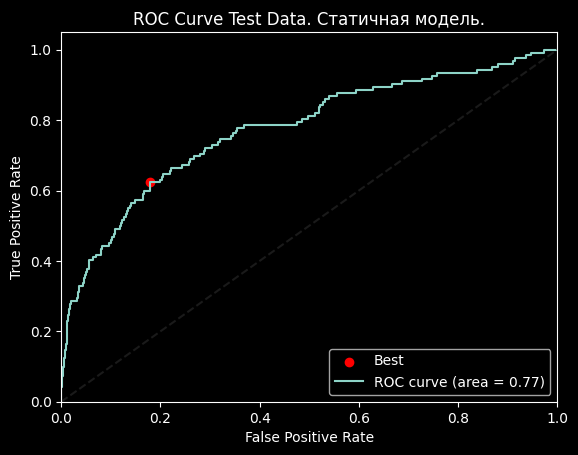

best threshold 0.014
ROC-AUC на тестовой выборке: 0.7733960874465735


In [54]:
# Предсказать вероятности для тестовой выборки
y_pred_static = model_static.predict_proba(X_test_static)[:, 1]
# Построение ROC-AUC кривой для тестового набора данных
fpr, tpr, thresholds = roc_curve(y_test_static, y_pred_static)
idx = np.argmax(tpr - fpr)
best_thresh = thresholds[idx]
# Вычислить ROC-AUC
roc_auc = roc_auc_score(y_test_static, y_pred_static)
plt.figure()
plt.scatter(fpr[idx], tpr[idx], marker="o", color="red", label="Best")
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Test Data. Статичная модель.')
plt.legend(loc="lower right")
plt.show()

print('best threshold', best_thresh.round(3))
print("ROC-AUC на тестовой выборке:", roc_auc)

In [55]:
# Важность признаков
feature_importance = model_static.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print('Важность признаков:')
print(feature_importance_df)

Важность признаков:
                        Feature  Importance
15       most_common_message_id   15.253195
1     days_since_first_purchase    9.856310
11                  total_spent    8.574927
2      days_since_last_purchase    8.268713
0             store_category_id    8.229832
9            max_purchase_price    7.823447
10           min_purchase_price    7.388336
8        average_purchase_price    6.988622
13       preferred_week_of_year    6.322362
12        preferred_day_of_week    4.281111
4   days_between_purchases_mean    3.750070
14      preferred_week_of_month    3.257571
7               total_purchases    2.808626
6         total_products_bought    2.548244
5    days_between_purchases_max    2.453815
3    days_between_purchases_min    2.194818


In [56]:
report = classification_report(y_test_static, y_pred_static > best_thresh, output_dict=True)
df_report = pd.DataFrame(report).round(2)
print(df_report)

                 0       1  accuracy  macro avg  weighted avg
precision     0.99    0.05      0.82       0.52          0.98
recall        0.82    0.61      0.82       0.72          0.82
f1-score      0.90    0.08      0.82       0.49          0.89
support    8814.00  122.00      0.82    8936.00       8936.00


### Выводы:
Исследование показало, что модель, основанная на keras с LSTM, демонстрирует высокий уровень точности и полноты, особенно в предсказании повторных покупок. Её ROC-AUC составил 0.804, а precision и recall для класса 1 равны 0.4 и 0.8 соответственно. Это говорит о хорошей способности модели выявлять и правильно классифицировать случаи повторных покупок.

В сравнении с моделью временного ряда и статичной моделью, модель с использованием keras и LSTM значительно превосходит по показателям качества классификации. Однако все модели показали определенные успехи в предсказании поведения клиентов.

Рекомендации по дальнейшему развитию проекта включают улучшение качества моделей путем дополнительной тонкой настройки гиперпараметров, использование более широкого спектра временных признаков для повышения точности прогнозов, а также активное использование полученных данных для персонализации маркетинговых стратегий и стимулирования возвращения клиентов.

Проект предоставляет нам ценные инсайты о поведении клиентов и дает нам основание для эффективных действий по увеличению числа возвратных клиентов и оптимизации маркетинговых стратегий.

#### Статичная модель:  
ROC-AUC: 0.773  
Precision для класса 1: 0.05    
Recall для класса 1: 0.61   
F1-score для класса 1: 0.08 
#### Модель keras со слоем LSTM:    
ROC-AUC: 0.804  
Precision для класса 1: 0.4    
Recall для класса 1: 0.8  
F1-score для класса 1: 0.53 
#### Модель временного ряда:    
ROC-AUC: 0.782  
Precision для класса 1: 0.39    
Recall для класса 1: 0.73   
F1-score для класса 1: 0.51 